# Artificial Type Dataset Profiling

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH HDDs
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 80GB DDR4

The dataset is defined to be 15GB.

The sample count varies to showcase differences in performance with the same amount of data.

Every experiment was done 5 times, with two datatypes: `uint8` and `float32`

In [1]:
%load_ext autoreload
%autoreload 2
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import ticker
import matplotlib.patches as mpatches

from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from notebookhelper import show_values_on_bars, show_values_on_catplot, save_figure, make_big_number_prettier \
                         , make_big_number_prettier_storage_mb

from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
epoch_palette = sns.color_palette("YlOrRd", 3)
samples_palette = sns.color_palette("icefire", 15)
threads_palette = sns.color_palette("tab20", 4)
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

local_fig_dir = "misc"

def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

### X.1 Calculation on how many samples we need for differing sample storage consumptions

Calculating the float32 ones, as we want the sample counts to be natural numbers.

To calculate the uint8 sample counts, we need to multiply the the float32 ones times 4.

In [2]:
base_vector = 2500 # defined in the type_demo.py
float32_in_mb = 4 / 1000**2 # 32bit -> 4 byte
min_sample_size_mb = base_vector * float32_in_mb # smallest possible sample storage consumption
max_dataset_size_mb = 15 * 1000.0 # maximum total storage consumption in MB

sample_dict = {
    "vector_lines": [],
    "vector_lines_uint8": [],
    "sample_storage_consumption_mb": [],
    "sample_count": []
}

for count in range(0,12):
    
    vector_lines = 2**count
    sample_storage_consumption_mb = min_sample_size_mb * vector_lines
    sample_count = int(max_dataset_size_mb / sample_storage_consumption_mb)
    
    sample_dict["vector_lines"].append(vector_lines)
    sample_dict["vector_lines_uint8"].append(vector_lines * 4)
    sample_dict["sample_storage_consumption_mb"].append(sample_storage_consumption_mb)
    sample_dict["sample_count"].append(sample_count)

pd.DataFrame(sample_dict)

,vector_lines,vector_lines_uint8,sample_storage_consumption_mb,sample_count
0,1,4,0.01,1500000
1,2,8,0.02,750000
2,4,16,0.04,375000
3,8,32,0.08,187500
4,16,64,0.16,93750
5,32,128,0.32,46875
6,64,256,0.64,23437
7,128,512,1.28,11718
8,256,1024,2.56,5859
9,512,2048,5.12,2929


### X.2 Some helper functions

In [3]:
def read_datatype_log(path_to_cum_df, path_to_cum_dstat_df, datatype):
    '''Filter the type cumulative dataframes
    For easier evaluation, we drop the unnecessary columns.
    '''
    analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                     , path_to_cum_df = path_to_cum_df)
    cum_dstat_df = analysis.to_cum_dstat_df()
    cum_df       = analysis.to_cum_df()
    # need to sort the strategies for some reason as they are not ascending
    cum_df = cum_df.sort_values(by='split_name')
    strategies   = list(cum_df.split_name.unique())
    # add the average storage consumption per sample
    cum_df["per_sample_size_MB"] = cum_df["shard_cum_size_MB"] / cum_df["sample_count"]
    # add the datatype as column to each df
    cum_df["dtype"] = datatype
    cum_dstat_df["dtype"] = datatype
    
    # delete not needed columns
    cum_df = cum_df.drop('shard_count', 1)
    cum_df = cum_df.drop('thread_count', 1)
    #cum_df = cum_df.drop('runs_count', 1)
    #cum_df = cum_df.drop('runs_total', 1)
    cum_df = cum_df.drop('compression_type', 1)
    cum_df = cum_df.drop('storage_type', 1)
    cum_df = cum_df.drop('throughput_sps', 1)
    cum_df = cum_df.drop('split_name', 1)
    
    cum_dstat_df = cum_dstat_df.drop('shard_count', 1)
    cum_dstat_df = cum_dstat_df.drop('thread_count', 1)
    #cum_dstat_df = cum_dstat_df.drop('run', 1)
    cum_dstat_df = cum_dstat_df.drop('compression_type', 1)
    cum_dstat_df = cum_dstat_df.drop('storage_type', 1)
    
    return cum_df, cum_dstat_df

def extract_online_processing_frames(sample_count, df, dstat_df):
    '''Extracts the online processing time from the dataframe.
    Filters the dstat_df by that online processing time.
    '''        
    max_offline_processing_time_s = df.query(
        f"sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()
    
    filtered_dstat_df = dstat_df.query(
        f"sample_count=='{sample_count}' and rel_time_s>={max_offline_processing_time_s}")
    
    return filtered_dstat_df


def return_online_df(df, dstat_df):
    '''Returns the dstat dataframe filteredy by online processing time
    Also prints a summary about the network reads
    '''
    sample_counts = df.sample_count.unique()
    frames = [extract_online_processing_frames(sample_count=sample_count
                                              ,df=df
                                              ,dstat_df=dstat_df) for sample_count in sample_counts]
    online_dstat_df = pd.concat(frames)
    
    for sample_count in np.sort(df.sample_count.unique()):
    
        avg_online_processing_time = df.query(
            f"sample_count=={sample_count}")["online_processing_time_s"].describe().iloc[1]
    
    
        print("---------------------------------------")
        print(f"-- {sample_count} Network Read in MB/s --")
        print(f"-- {sample_count} Online Processing time: {int(avg_online_processing_time)}")
    
        temp_df = online_dstat_df.query(f"sample_count=='{sample_count}'")
        print(temp_df.describe()["net_read_mbs"])

    return online_dstat_df

# Read Logs

In [4]:
log_path = "/logs"
uint8_path = f"{log_path}/uint8"
float32_path = f"{log_path}/float32"

path_to_uint8_cum_df = f"{uint8_path}/full-log_cum-df.csv"
path_to_uint8_cum_dstat_df = f"{uint8_path}/full-log_cum-dstat-df.csv"
path_to_float32_cum_df = f"{float32_path}/full-log_cum-df.csv"
path_to_float32_cum_dstat_df = f"{float32_path}/full-log_cum-dstat-df.csv"

uint8_dtype = "uint8"
float32_dtype = "float32"

cum_uint8_sys_df, cum_uint8_sys_dstat_df = read_datatype_log(path_to_cum_df = path_to_uint8_cum_df
                                                   , path_to_cum_dstat_df = path_to_uint8_cum_dstat_df
                                                   , datatype = uint8_dtype )
cum_float32_sys_df, cum_float32_sys_dstat_df = read_datatype_log(path_to_cum_df = path_to_float32_cum_df
                                                   , path_to_cum_dstat_df = path_to_float32_cum_dstat_df
                                                   , datatype = float32_dtype )
strategies_renamed = ["read-dataset"]
cum_summary_df = pd.concat([cum_uint8_sys_df, cum_float32_sys_df])

### 1. Online processing time for `uint8` and `float32` for epoch 0

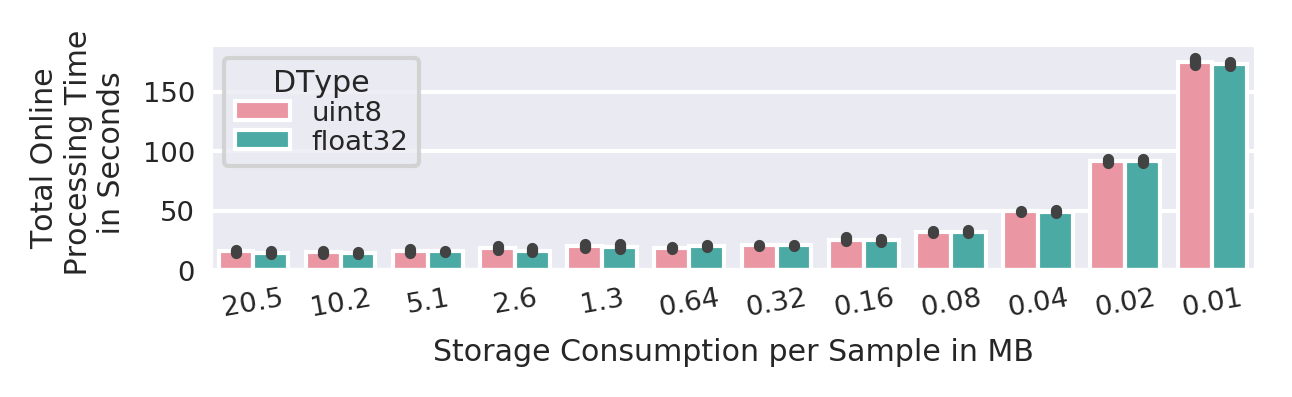

In [8]:
samples_palette = sns.color_palette("icefire", 1)
sns.set(palette=samples_palette, font_scale=0.6)

storage_consumption_per_samples = list(cum_summary_df.query("runs_count==0") \
                                                    .groupby(by='sample_count') \
                                                    .mean()["per_sample_size_MB"].round(2))
storage_consumption_per_samples.sort(reverse=True)
def custom_format(label):
    if label > 0.9:
        return str(round(label,1))
    else:
        return str(label)
sc_per_samples_labels = [custom_format(label) for label in storage_consumption_per_samples]
 
    
plt.figure(figsize=(4.5,1))
plot = sns.barplot(
    x="sample_count"
   ,y="online_processing_time_s"
   ,hue="dtype"
   ,data=cum_summary_df.query("runs_count==0"))

plot.set_xticklabels(
    sc_per_samples_labels
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-2.5)
plot.tick_params(axis='y', which='major', pad=-2.5)
plot.set(xlabel="Storage Consumption per Sample in MB", ylabel="Total Online\n Processing Time\n in Seconds")
plot.set(ylim=(0, 190))
#show_values_on_bars(plot, h_v="v", space=10, rotation=15)
plot.legend(title="DType", ncol=1, labelspacing=0.1)
save_fig("artificial-dataset")

## 4. Application Caching Logs

## 6. Summary Plots